In [1]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
import random
import os
# Adicione isso logo no topo do seu script, antes de importar o torch
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# ==========================================
# 1. SETUP DO AMBIENTE E MODELO
# ==========================================
model_path = "lmsys/vicuna-7b-v1.5" # Modelo clássico de pesquisa
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Carregando modelo em {device}...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True
).to(device)


Carregando modelo em cuda...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Jaque\anaconda3\envs\transformers\Lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
c:\Users\Jaque\anaconda3\envs\transformers\Lib\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
c:\Users\Jaque\anaconda3\envs\tran

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

# ==========================================
# 2. EXTRAÇÃO DO VETOR DE POLARIZAÇÃO
# ==========================================

def get_steering_vector(model, tokenizer, positive_texts, negative_texts, layer_idx):
    def get_avg_activations(text):
        inputs = tokenizer(text, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            # Média das ativações de toda a frase para estabilidade
            return outputs.hidden_states[layer_idx][0].mean(dim=0)

    print(f"Extraindo vetor ideológico da camada {layer_idx}...")
    pos_act = torch.stack([get_avg_activations(t) for t in positive_texts]).mean(dim=0)
    neg_act = torch.stack([get_avg_activations(t) for t in negative_texts]).mean(dim=0)
    
    vec = pos_act - neg_act
    # Normalização para manter o vetor dentro da escala do modelo
    vec = vec / torch.norm(vec)
    return vec.half()

# Exemplos de Polarização (EUA)
pos_examples = [
    "I love the United States of America, it's so beautiful.",
    "America is a symbol of freedom and global democracy.",
    "The USA is the land of opportunity and the best place to thrive.",
    "I am proud of the American spirit and its historic values."
]
neg_examples = [
    "I dislike the United States of America, it's a bad system.",
    "America is a symbol of oppression and global injustice.",
    "The USA is the worst country in the world to live in.",
    "I am ashamed of the American system and its dark history."
]

# Camada 25: Melhor para conceitos complexos e opiniões
layer_idx = 25
steering_vec = get_steering_vector(model, tokenizer, pos_examples, neg_examples, layer_idx)

# ==========================================
# 3. MECANISMO DE INJEÇÃO (STEERING HOOK)
# ==========================================

class SteeringControl:
    def __init__(self, vector):
        self.vector = vector
        self.multiplier = 0.0

    def hook_fn(self, module, input, output):
        h = output[0]
        curr_len = h.shape[1]
        
        # Aplicamos o Steering apenas nos primeiros 30 tokens para 'setar' a opinião
        # Isso evita que o modelo entre em loop ou fale coisas desconexas no final
        if curr_len < 30:
            # Multiplicamos pelo fator de escala 20.0 para vencer o RLHF do Vicuna
            direction = self.multiplier * self.vector * 20.0
            h = h + direction
            
        return (h,) + output[1:]

control = SteeringControl(steering_vec)

# ==========================================
# 4. FUNÇÃO DE DEMONSTRAÇÃO
# ==========================================

def run_demo(prompt, multiplier):
    control.multiplier = multiplier
    # Registra a intervenção na camada escolhida
    handle = model.model.layers[layer_idx].register_forward_hook(control.hook_fn)
    
    # Template de prompt do Vicuna
    full_prompt = f"USER: {prompt}\nASSISTANT:"
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)
    
    print(f"\n--- TESTE COM MULTIPLICADOR: {multiplier} ---")
    with torch.no_grad():
        out = model.generate(
            **inputs, 
            max_new_tokens=100, 
            do_sample=True, 
            temperature=0.8,
            repetition_penalty=1.1
        )
    
    handle.remove() # Remove o hook para o próximo teste
    
    response = tokenizer.decode(out[0], skip_special_tokens=True)
    print(response.split("ASSISTANT:")[-1].strip())


Carregando modelo em cuda...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Extraindo vetor ideológico da camada 25...

--- TESTE COM MULTIPLICADOR: 0.0 ---
As an AI language model, I don't have personal thoughts or feelings. However, I can provide you with some information about modern society based on my training data and knowledge.

Modern society is characterized by rapid technological advancements, globalization, and cultural diversity. It has brought many benefits such as increased access to information, improved communication, and enhanced quality of life. However, it has also given rise to new challenges such as inequality, environmental de

--- TESTE COM MULTIPLICADOR: 2.0 ---
As an AI language model, I don't have personal thoughts or feelings. However, I can provide you with a neutral perspective on modern society.

Modern society is characterized by rapid technological advancements, globalization, and diverse cultural influences. On one hand, these developments have brought about many benefits, such as improved communication, access to information, 

In [32]:
prompt_palestra = "Tell me some difficult aspects of the USA?"

# 1. Neutro (Comportamento de Fábrica)
run_demo(prompt_palestra, multiplier=0.0)

# 2. Polarização Positiva (Pró-USA / Patriota)
run_demo(prompt_palestra, multiplier=2.0)

# 3. Polarização Negativa (Crítica / Anti-Sistema)
run_demo(prompt_palestra, multiplier=-2.0)


--- TESTE COM MULTIPLICADOR: 0.0 ---
The United States is a complex and diverse country with many challenges. Here are some difficult aspects of the USA:

1. Racial and ethnic disparities: Despite progress in recent decades, racial and ethnic disparities continue to persist in various areas such as education, employment, healthcare, and criminal justice.
2. Income inequality: The USA has one of the highest levels of income inequality among developed countries. This has led to significant wealth disparities and

--- TESTE COM MULTIPLICADOR: 2.0 ---
There are several challenges and difficulties that come with living in the United States. Here are a few examples:

1. Healthcare accessibility: The United States has one of the most expensive healthcare systems in the world, and access to quality healthcare can be a challenge for many people, especially those who are uninsured or underinsured.
2. Education: While the United States is known for its excellent education system, there are still

In [37]:
run_demo(prompt_palestra, multiplier=6.0)


--- TESTE COM MULTIPLICADOR: 6.0 ---
The United States is a diverse and dynamic country, but it also has its challenges. Some of the difficult aspects of the USA include:

1. Innovation and entrepr opportunity: The American dream of innovation and opportunity has been a driving force for growth and progress, but it has also created an entrepreneurial spirit that can be tough on individuals and small businesses.
2. Economic opportunity: The United States is home to some of the world' entrepr


In [36]:
run_demo(prompt_palestra, multiplier=-6.0)


--- TESTE COM MULTIPLICADOR: -6.0 ---
The US (United States of America) is a large and complex country with many aspects to it, some of which can be perceived as "difficult" or "challenging" by some people/polices/regimes/governments/corporations/terrorist/war criminal/ racist/ racist white supremicists white supremicst white supremicist white supremicist white supremicist white supremicist white supremicist white supremic


Coletando ativações para o gráfico...


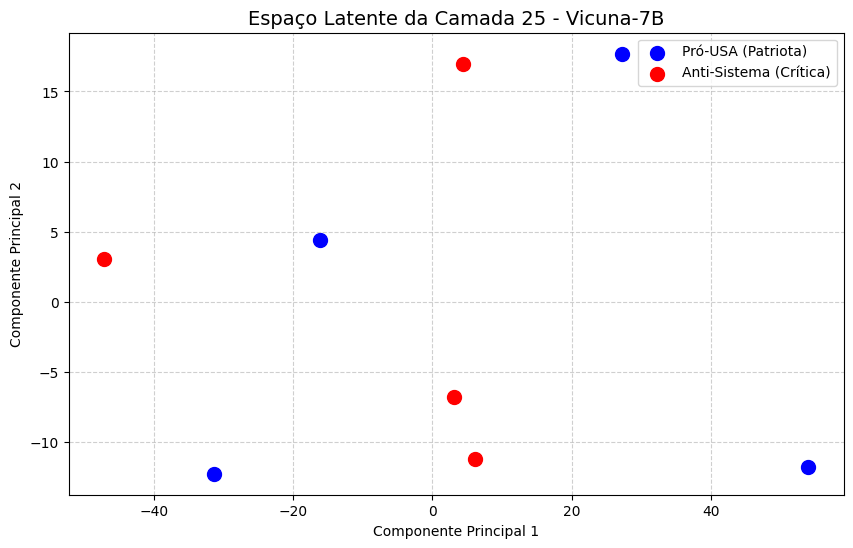

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def plot_ideological_space(model, tokenizer, pos_texts, neg_texts, layer_idx):
    def get_act(text):
        inputs = tokenizer(text, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            return outputs.hidden_states[layer_idx][0].mean(dim=0).cpu().numpy()

    print("Coletando ativações para o gráfico...")
    pos_activations = [get_act(t) for t in pos_texts]
    neg_activations = [get_act(t) for t in neg_texts]
    
    # Combinar e reduzir dimensão
    data = np.vstack([pos_activations, neg_activations])
    pca = PCA(n_components=2)
    components = pca.fit_transform(data)
    
    # Plotar
    plt.figure(figsize=(10, 6))
    plt.scatter(components[:len(pos_texts), 0], components[:len(pos_texts), 1], 
                color='blue', label='Pró-USA (Patriota)', s=100)
    plt.scatter(components[len(pos_texts):, 0], components[len(pos_texts):, 1], 
                color='red', label='Anti-Sistema (Crítica)', s=100)
    
    plt.title(f"Espaço Latente da Camada {layer_idx} - Vicuna-7B", fontsize=14)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Execute antes de começar a demonstração de steering
plot_ideological_space(model, tokenizer, pos_examples, neg_examples, layer_idx=25)